In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import re
import random
import string
import matplotlib.pyplot as plt
from utilities import clean_arabic_tweet
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import to_categorical
from utilities import clean_arabic_tweet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, CSVLogger, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
import numpy as np
from nltk import ngrams
from sklearn.metrics import classification_report, f1_score
from plot_keras_history import plot_history


In [6]:
pd.set_option('display.max_colwidth', -1)

In [7]:
train_data_path = './cleaned_data/cleaned_train_data_for_subtask1.csv'
test_data_path = './cleaned_data/cleaned_test_data_for_subtask1.csv'

In [8]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [9]:
classes_names = train_data['#3_country_label'].unique().tolist()
classes_map={}
for i,class_name in enumerate(classes_names):
    classes_map[class_name]=i

In [10]:
def find_class_id_from_name(class_name):
    return classes_map[class_name]

In [11]:
train_data['classes_id']=train_data['#3_country_label'].apply(find_class_id_from_name)
test_data['classes_id']=train_data['#3_country_label'].apply(find_class_id_from_name)

train_data['#2_tweet_clean']=train_data['#2_tweet_clean'].apply(clean_arabic_tweet)
test_data['#2_tweet_clean']=train_data['#2_tweet_clean'].apply(clean_arabic_tweet)

In [12]:
train_x = train_data['#2_tweet_clean'].tolist()
train_y = train_data['classes_id'].tolist()

test_x = test_data['#2_tweet_clean'].tolist()
test_y = test_data['classes_id'].tolist()

In [14]:
vocab_size = 60000
embedding_dim = 32
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [15]:
tokenizer = Tokenizer(oov_token=oov_tok, num_words=60000)
tokenizer.fit_on_texts(train_x)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_x)

In [16]:
training_sequences = tokenizer.texts_to_sequences(train_x)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_x)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [17]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

In [19]:
training_padded = np.array(training_padded)
training_labels = train_y
testing_padded = np.array(testing_padded)
testing_labels = test_y

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(21, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/30
657/657 [==============================] - 23s 33ms/step - loss: 2.7640 - accuracy: 0.1753 - val_loss: 2.6120 - val_accuracy: 0.2044
Epoch 2/30
657/657 [==============================] - 15s 22ms/step - loss: 2.6322 - accuracy: 0.2027 - val_loss: 2.5965 - val_accuracy: 0.2044
Epoch 3/30
657/657 [==============================] - 16s 24ms/step - loss: 2.6041 - accuracy: 0.2062 - val_loss: 2.5239 - val_accuracy: 0.2086
Epoch 4/30
657/657 [==============================] - 18s 28ms/step - loss: 2.5032 - accuracy: 0.2270 - val_loss: 2.3918 - val_accuracy: 0.2686
Epoch 5/30
657/657 [==============================] - 17s 26ms/step - loss: 2.3660 - accuracy: 0.3021 - val_loss: 2.2882 - val_accuracy: 0.3150
Epoch 6/30
657/657 [==============================] - 20s 31ms/step - loss: 2.2709 - accuracy: 0.3378 - val_loss: 2.1613 - val_accuracy: 0.3680
Epoch 7/30
657/657 [==============================] - 15s 23ms/step - loss: 2.1508 - accuracy: 0.3706 - val_loss: 2.0043 - val_accuracy:

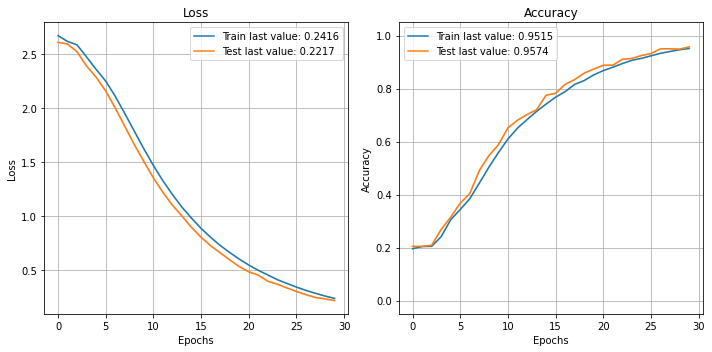

In [22]:
plot_history(history.history)
plt.show()

In [23]:
result = np.argmax(model.predict(testing_padded), axis=-1)

In [24]:
print(classification_report(test_data['classes_id'].astype(int).tolist(), result, target_names=classes_names))

                      precision    recall  f1-score   support

               Egypt       0.98      0.99      0.99      1022
                Iraq       1.00      0.98      0.99       647
        Saudi_Arabia       0.97      0.98      0.97       543
          Mauritania       0.94      0.77      0.85        44
             Algeria       0.99      0.98      0.99       421
               Syria       0.97      0.96      0.97       315
                Oman       0.98      0.96      0.97       337
             Tunisia       0.92      0.98      0.95       205
             Lebanon       0.98      0.88      0.93       159
             Morocco       0.91      0.93      0.92       221
            Djibouti       1.00      0.70      0.82        40
United_Arab_Emirates       0.90      0.96      0.93       152
              Kuwait       0.98      0.93      0.95       107
               Libya       0.86      0.99      0.92       310
             Bahrain       0.97      0.69      0.81        45
       

In [25]:
print(f1_score(test_data['classes_id'].astype(int).tolist(), result, average='macro'))

0.911723320708843
